## RGB Histogram Classifier

This is an attempt to create a Histogram classifier that I have learned from the Computer Vision course at university. I used this dataset from Kaggle: https://www.kaggle.com/sriramr/apples-bananas-oranges. First, I only selected the subsets of good fruits, not the ones with rotten fruits. Among the good fruits, which are apple, orange and banana: I divided it into train & test set. In the test set, each fruit has 18 images, while there are about 200 train images for each fruit.

Even though I make use of the term "train", it does not indicate that the Histogram classifier would become trainable like a ML model, but the classifier uses these train images to propose how an apple or orange could look like, as histogram classifier is one of the nearest-neighbor algorithms.

This notebook walks through these essential steps:
1. Load images
2. Simple preprocessing
3. Create RGB histograms
4. Compute the shortest distance

In [19]:
from matplotlib import pyplot as plt
import glob
import numpy as np
from skimage import color

In [20]:
def readImages(img_class, dataset="train"):
    images = []
    filenames = glob.glob(dataset + '/' + img_class + '/*.png')
    for filename in filenames:
        images.append(plt.imread(filename))
    print("There are {} {}".format(len(images), img_class))
    return images

In [21]:
def convertToRGB(rgba_images):
    rgb_images = []
    for rgba_image in rgba_images:
        rgb_images.append(color.rgba2rgb(rgba_image))
    return rgb_images

There are 214 apples


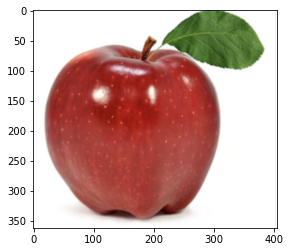

There are 200 banana


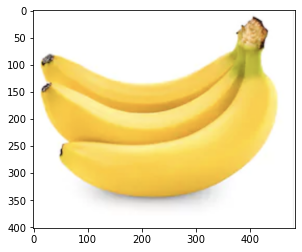

There are 188 oranges


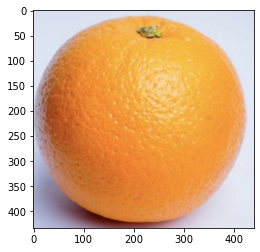

In [22]:
apples = convertToRGB(readImages('apples'))
plt.imshow(apples[0])
plt.show()

banana = convertToRGB(readImages('banana'))
plt.imshow(banana[0])
plt.show()

oranges = convertToRGB(readImages('oranges'))
plt.imshow(oranges[0])
plt.show()

There are 18 apples


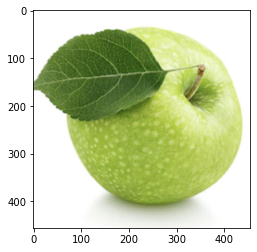

There are 18 banana


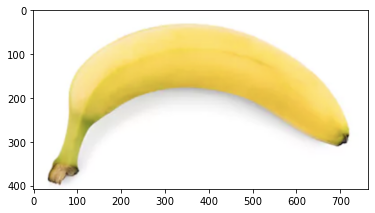

There are 18 oranges


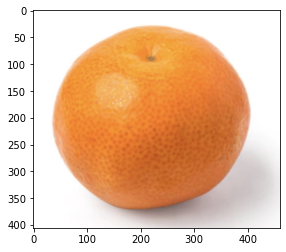

In [24]:
testApples = convertToRGB(readImages('apples', 'test'))
plt.imshow(testApples[0])
plt.show()

testBanana = convertToRGB(readImages('banana', 'test'))
plt.imshow(testBanana[0])
plt.show()

testOranges = convertToRGB(readImages('oranges', 'test'))
plt.imshow(testOranges[0])
plt.show()

Realizing that all images have different shapes, I decided to take the minimum height and width in order to resize all the images, bringing them to the same dimension.

In [25]:
for orange in oranges[:5]:
    print(orange.shape)

(434, 440, 3)
(222, 240, 3)
(316, 326, 3)
(370, 488, 3)
(386, 392, 3)


The shape I determined is (128,144) for all 3 color channels.

In [26]:
image_shape_x = []
image_shape_y = []

fruits = [] 
fruits = oranges + banana + apples + testOranges + testBanana + testApples

for fruit in fruits:
    image_shape_x.append(fruit.shape[0])
    image_shape_y.append(fruit.shape[1])

min_x = min(image_shape_x)
min_y = min(image_shape_y)
print((min_x, min_y))

(128, 144)


In [27]:
import cv2

In [28]:
resized_oranges = [cv2.resize(orange, (min_x,min_y)) for orange in oranges]
resized_apples = [cv2.resize(apple, (min_x,min_y)) for apple in apples]
resized_banana = [cv2.resize(banani, (min_x,min_y)) for banani in banana]

Once the images are resized, I created 3 histograms, each one for one color channel. Each histogram has 51 bins, while the bin size is 5. Then we stack them in a vector / list.

In [29]:
def create_rgb_histogram(resized_fruits):
    rgb_histograms = []
    for fruit in resized_fruits:
        red = np.histogram(fruit[:,:,0], bins = 51, range = (0,1))
        green = np.histogram(fruit[:,:,1], bins = 51, range = (0,1))
        blue = np.histogram(fruit[:,:,2], bins = 51, range = (0,1))
        rgb_histograms.append(np.hstack((red[0], green[0], blue[0])))
    return rgb_histograms

In [30]:
orange_histograms = create_rgb_histogram(resized_oranges)
banana_histograms = create_rgb_histogram(resized_banana)
apple_histograms = create_rgb_histogram(resized_apples)

Now i create the list of train histograms with all 3 fruits, as well as the separated list of the ground truth values.

In [31]:
trainHistograms = orange_histograms + banana_histograms + apple_histograms
trainGroundTruth = len(orange_histograms) * [0] + len(banana_histograms) * [1] + len(apple_histograms) * [2]

As the test images were already loaded, we also need to resize them before creating the channel-wise histograms and then we stack them in a vector.

In [32]:
resized_testOranges = [cv2.resize(orange, (min_x,min_y)) for orange in testOranges]
resized_testApples = [cv2.resize(apple, (min_x,min_y)) for apple in testApples]
resized_testBanana = [cv2.resize(banani, (min_x,min_y)) for banani in testBanana]

In [33]:
testOrange_histograms = create_rgb_histogram(resized_testOranges)
testBanana_histograms = create_rgb_histogram(resized_testBanana)
testApple_histograms = create_rgb_histogram(resized_testApples)

I create the list of histograms for test images, as well as the list of test ground truth.

In [34]:
testHistograms = testOrange_histograms + testBanana_histograms + testApple_histograms
testGroundTruth = len(testOrange_histograms) * [0] + len(testBanana_histograms) * [1] + len(testApple_histograms) * [2]

I make use of Euclidean Distance to determine which train image is the closest to the current test image (the simultaneous comparison of the RGB histograms), in order to make the prediction, which class the test image belongs to. #nearestneighbor

In [46]:
def computeShortestDistance(currentHistogram, trainHistograms, trainGroundTruth):
    euclideanDistances = []
    for idx, val in enumerate(trainHistograms):
        euclideanDistances.append(np.linalg.norm(val - currentHistogram))
    shortestDistance = min(euclideanDistances)
    shortestDistanceIdx = euclideanDistances.index(shortestDistance)
    return trainGroundTruth[shortestDistanceIdx]

Once we have the algorithm to compute the shortest distance from the one test image to all train images, we execute the for-loop to make a prediction for all test images. 

In [47]:
predictions = []
for testHistogram in testHistograms:
    predictions.append(computeShortestDistance(testHistogram, trainHistograms, trainGroundTruth))

In [51]:
print("Accuracy: {}%".format(sum(1 for x,y in zip(predictions,testGroundTruth) if x == y) / len(predictions) * 100.0))

Accuracy: 98.14814814814815%


In [55]:
def labelOutput(idx):
    if idx == 0:
        return 'an orange'
    elif idx == 1:
        return 'a banana'
    elif idx == 2:
        return 'an apple'

Example:

This is an orange, the classifier thinks it's an orange.


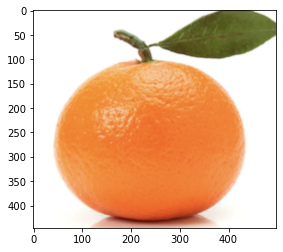

This is a banana, the classifier thinks it's a banana.


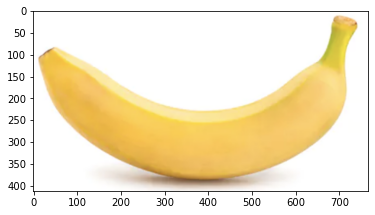

This is an apple, the classifier thinks it's an apple.


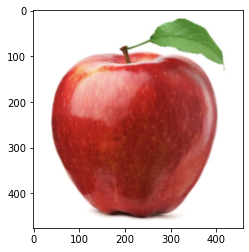

In [62]:
test_Fruits = testOranges + testBanana + testApples

idx = 5
print("This is {}, the classifier thinks it's {}.".format(labelOutput(testGroundTruth[idx]), labelOutput(predictions[idx])))
plt.imshow(test_Fruits[idx])
plt.show()

idx = 23
print("This is {}, the classifier thinks it's {}.".format(labelOutput(testGroundTruth[idx]), labelOutput(predictions[idx])))
plt.imshow(test_Fruits[idx])
plt.show()

idx = 41
print("This is {}, the classifier thinks it's {}.".format(labelOutput(testGroundTruth[idx]), labelOutput(predictions[idx])))
plt.imshow(test_Fruits[idx])
plt.show()